In [1]:
# -*- coding: utf-8 -*-
"""
Created on 30/05/2023

@author: Abdelmalek H
"""
import os
import numpy as np
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import Sequence
from sklearn.model_selection import KFold
from keras.applications.vgg19 import VGG19
from keras.layers import Flatten, Dense
from keras.models import Model
from keras.optimizers import Adam


class CustomDataGenerator(Sequence):
    """Custom data generator for image and age data."""

    def __init__(self, image_paths, ages, batch_size, image_size, augment):
        self.image_paths = image_paths
        self.ages = ages
        self.batch_size = batch_size
        self.image_size = image_size
        self.augment = augment
        if self.augment:
            self.datagen = ImageDataGenerator(
                rotation_range=30,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                vertical_flip=True,
                fill_mode='nearest'
            )

    def __len__(self):
        """Get the number of batches per epoch."""
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        """Get a batch of images and ages."""
        batch_image_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = []
        batch_ages = []

        for i, image_path in enumerate(batch_image_paths):
            image, age = self.load_and_preprocess_image(image_path)
            augmented_image = self.apply_image_augmentation(image)
            batch_images.append(augmented_image)
            batch_ages.append(age)

        batch_images = np.array(batch_images)
        batch_ages = np.array(batch_ages)

        return batch_images, batch_ages

    def load_and_preprocess_image(self, image_path):
        """Load and preprocess an image from the given path."""
        npzfile = np.load(image_path)
        image = npzfile['image']
        Age = np.load(image_path)['Age']

        image_resized = cv2.resize(image, self.image_size)
        image_norm = (image_resized.astype('float32') - np.min(image_resized)) / (
                    np.max(image_resized) - np.min(image_resized))

        if len(image.shape) == 2:
            image_tri = np.repeat(image_norm[:, :, np.newaxis], 3, axis=2)
        else:
            image_tri = image_norm

        return image_tri, Age

    def apply_image_augmentation(self, image):
        """Apply image augmentation on the given image."""
        if self.augment:
            augmented_image = self.datagen.random_transform(image)
        else:
            augmented_image = image
        return augmented_image


if __name__ == "__main__":
    # Define paths and parameters
    train_path = r'E:/Papier/AIAGE/Base/reseau de neurones/save/train'
    test_path = r'E:/Papier/AIAGE/Base/reseau de neurones/save/test'
    batch_size = 32
    image_size = (224, 224)
    num_epochs = 10
    k = 5
    seed = 7
    np.random.seed(seed)

    # Load image paths and ages
    train_image_paths = [os.path.join(root, f) for root, dirs, files in os.walk(train_path) for f in files]
    train_ages = [np.load(image_path)['Age'] for image_path in train_image_paths]
    test_image_paths = [os.path.join(root, f) for root, dirs, files in os.walk(test_path) for f in files]
    test_ages = [np.load(image_path)['Age'] for image_path in test_image_paths]

    # Initialize the KFold object
    kfold = KFold(n_splits=k, shuffle=True, random_state=seed)

    # Initialize variables
    cv_scores = []

    # Loop through the folds in KFold and train the model
    for i, (train_index, test_index) in enumerate(kfold.split(train_image_paths, train_ages)):
        print("======================================")
        print("Iteration = ", i+1)

        # Split the data into train and validation sets
        X_train, X_val = np.array(train_image_paths)[train_index], np.array(train_image_paths)[test_index]
        y_train, y_val = np.array(train_ages)[train_index], np.array(train_ages)[test_index]

        # Create data generators
        train_data_generator = CustomDataGenerator(X_train, y_train, batch_size, image_size, augment=True)
        val_data_generator = CustomDataGenerator(X_val, y_val, batch_size, image_size, augment=False)
        test_data_generator = CustomDataGenerator(test_image_paths, test_ages, batch_size, image_size, augment=False)

        # Load the VGG19 model
        base_model = VGG19(weights='//chu-lyon.fr/bureautique/TOUS_COMMUNS/BIOSTAT_COMMUN/etude60/6458 stage Perla El Khoueiry/analyse/AI_LA/Perla/reseaux-Age_binaire/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
                       include_top=False, input_shape=(224, 224, 3))

        # Set layers in the model as trainable
        for layer in base_model.layers:
            layer.trainable = False

        # Add layers on top of the VGG19 model
        x = base_model.output
        x = Flatten()(x)
        x = Dense(256, activation='relu')(x)
        x = Dense(128, activation='relu')(x)
        output = Dense(1, activation='linear')(x)
        model = Model(inputs=base_model.input, outputs=output)

        # Compile the model with specified loss function, optimizer and metrics
        model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.0001), metrics=['mean_absolute_error'])

        # Print the summary of the model
        model.summary()

        # Train the model
        history = model.fit(train_data_generator, epochs=num_epochs, validation_data=val_data_generator)

        # Evaluate the model's performance
        scores = model.evaluate(val_data_generator)

        # Append score to cv_scores list
        cv_scores.append(scores[1] * 100)

        # Print performance metrics and history
        print("MSE: %.2f" % (scores[0]))
        print("MAE: %.2f" % (scores[1]))

    # Calculate the mean and standard deviation of the performance metrics
    accuracy = np.mean(cv_scores)
    std = np.std(cv_scores)
    print("Accuracy: %.2f%% (+/- %.2f%%)" % (accuracy, std))

Iteration =  1
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 12

C:\ProgramData\Anaconda3\envs\vision\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
253/253 [==============================] - 1079s 4s/step - loss: 15.8755 - mean_absolute_error: 3.1385 - val_loss: 10.0336 - val_mean_absolute_error: 2.7075
Epoch 2/10
253/253 [==============================] - 1090s 4s/step - loss: 10.5469 - mean_absolute_error: 2.7229 - val_loss: 9.5027 - val_mean_absolute_error: 2.6006
Epoch 3/10
253/253 [==============================] - 1098s 4s/step - loss: 10.2816 - mean_absolute_error: 2.6788 - val_loss: 9.6217 - val_mean_absolute_error: 2.5140
Epoch 4/10
253/253 [==============================] - 1189s 5s/step - loss: 10.3633 - mean_absolute_error: 2.6719 - val_loss: 9.5669 - val_mean_absolute_error: 2.6530
Epoch 5/10
253/253 [==============================] - 1103s 4s/step - loss: 10.0089 - mean_absolute_error: 2.6363 - val_loss: 9.4860 - val_mean_absolute_error: 2.6313
Epoch 6/10
253/253 [==============================] - 1092s 4s/step - loss: 9.9563 - mean_absolute_error: 2.6117 - val_loss: 8.9056 - val_mean_absolute_error: 2.442

                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       295168    
                                                                 
 block3_conv2 (Conv2D)       (None, 56, 56, 256)       590080    
                                                                 
 block3_conv3 (Conv2D)       (None, 56, 56, 256)       590080    
                                                                 
 block3_conv4 (Conv2D)       (None, 56, 56, 256)       590080    
                                                                 
 block3_po

                                                                 
 dense_9 (Dense)             (None, 256)               6422784   
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 26,480,193
Trainable params: 6,455,809
Non-trainable params: 20,024,384
_________________________________________________________________
Epoch 1/10
253/253 [==============================] - 1030s 4s/step - loss: 15.7330 - mean_absolute_error: 3.1413 - val_loss: 10.3696 - val_mean_absolute_error: 2.7133
Epoch 2/10
253/253 [==============================] - 1055s 4s/step - loss: 10.5820 - mean_absolute_error: 2.7251 - val_loss: 12.3226 - val_mean_absolute_error: 2.7329
Epoch 3/10
253/253 [==============================

In [5]:
model.save("//chu-lyon.fr/bureautique/TOUS_COMMUNS/BIOSTAT_COMMUN/etude60/6458 stage Perla El Khoueiry/analyse/AI_LA/Perla/model_sauvegarder/VGG19_continue.h5") 


In [2]:
# Prediction 
y_pred_list=[]
y_pred = model.predict(test_data_generator)
y_pred_list.append(y_pred)


79/79 [==============================] - 273s 3s/step


<function matplotlib.pyplot.show(close=None, block=None)>

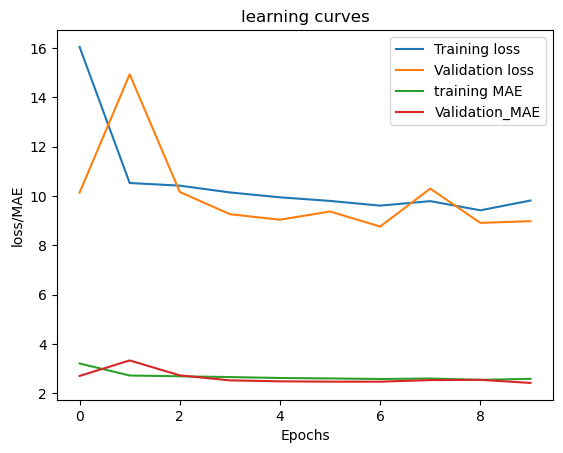

In [3]:
##########learning curve#########
import matplotlib.pyplot as plt
import numpy as np
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.plot(history.history['mean_absolute_error'], label='training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation_MAE')
plt.xlabel('Epochs')
plt.ylabel('loss/MAE')
plt.legend()
plt.title('learning curves')
plt.show

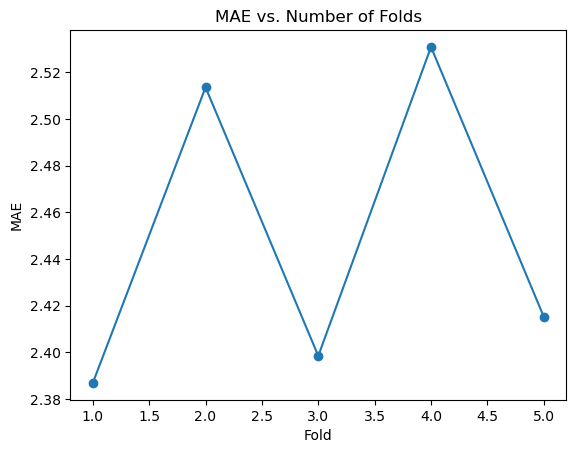

In [4]:
# Mean Absolute Error (MAE) vs. Number of Folds
plt.plot(range(1, k+1), [score/100 for score in cv_scores], marker='o')
plt.xlabel('Fold')
plt.ylabel('MAE')
plt.title('MAE vs. Number of Folds')
plt.show()


ValueError: x and y must have same first dimension, but have shapes (5,) and (1,)

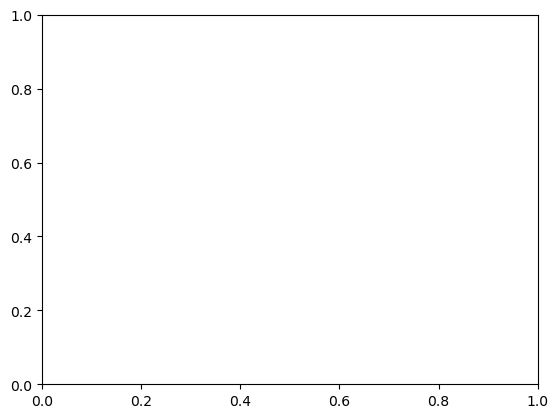

In [21]:
######Mean Absolute error vs number of fold######
plt.plot(range(1, k+1), scores[0], marker='o')
plt.xlabel('Fold')
plt.ylabel('MSE')
plt.title('MSE vs. Number of Folds')
plt.show()

In [48]:
# Mean Absolute Error (MAE) vs. Number of Folds
plt.plot(range(1, k+1), (cv_scores/100), marker='o')
plt.xlabel('Fold')
plt.ylabel('cv_scores')
plt.title('MAE vs. Number of Folds')
plt.show()

TypeError: unsupported operand type(s) for /: 'list' and 'int'

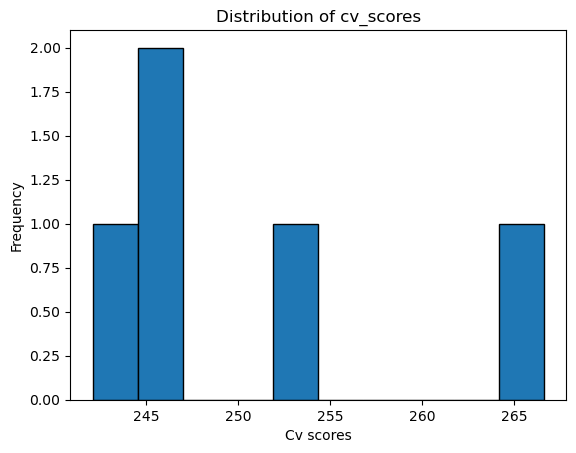

In [24]:
# Mean Absolute Error (MAE) vs. Number of Folds
plt.hist(cv_scores,bins=10, edgecolor='black')
plt.xlabel('Cv scores')
plt.ylabel('Frequency')
plt.title('Distribution of cv_scores')
plt.show()

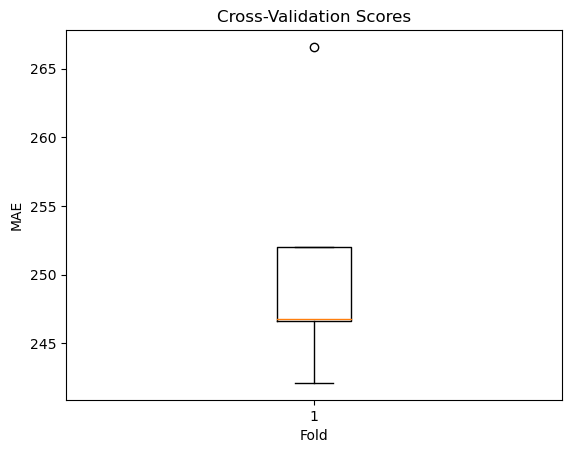

In [11]:
# Box Plot of Cross-Validation Scores
plt.boxplot(cv_scores)
plt.xlabel('Fold')
plt.ylabel('MAE')
plt.title('Cross-Validation Scores')
plt.show()

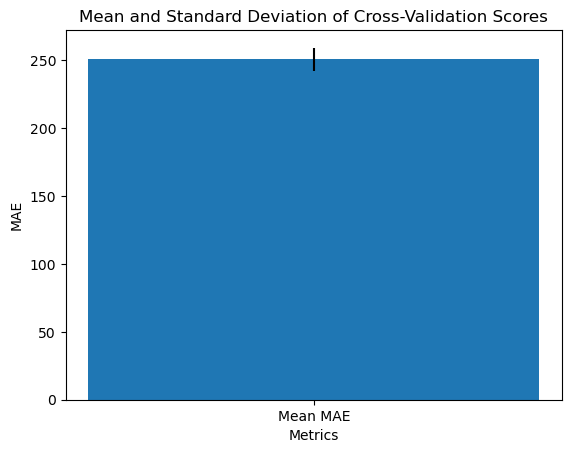

In [18]:
# Mean and Standard Deviation of Cross-Validation Scores
plt.bar('Mean MAE', accuracy, yerr=std)
plt.xlabel('Metrics')
plt.ylabel('MAE')
plt.title('Mean and Standard Deviation of Cross-Validation Scores')
plt.show()

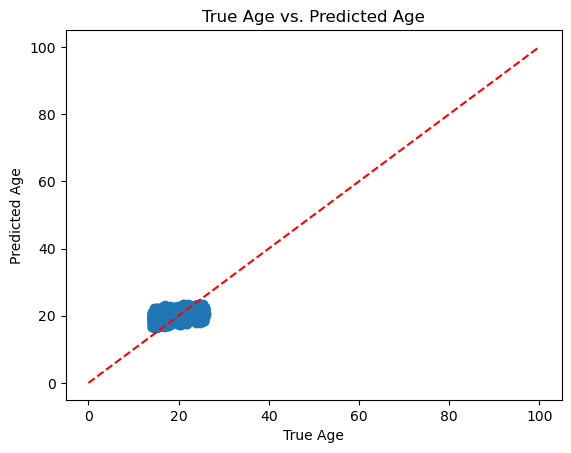

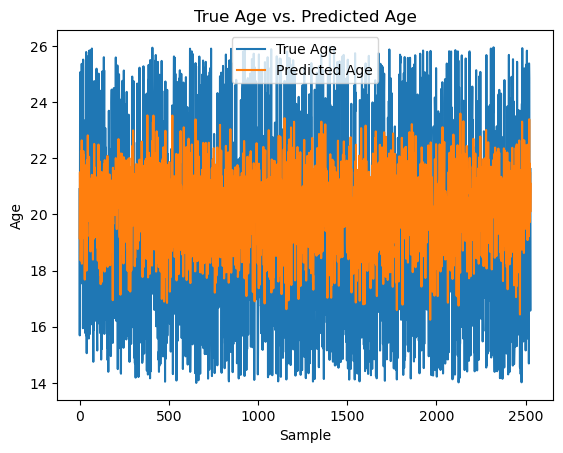

In [14]:
# Scatter plot
plt.scatter(test_ages, y_pred)
plt.plot([0, 100], [0, 100], color='red', linestyle='--')  # Plotting the ideal line where y_pred = y_true
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.title('True Age vs. Predicted Age')
plt.show()

# Line plot
plt.plot(test_ages, label='True Age')
plt.plot(y_pred, label='Predicted Age')
plt.xlabel('Sample')
plt.ylabel('Age')
plt.title('True Age vs. Predicted Age')
plt.legend()
plt.show()

In [16]:
from sklearn.metrics import r2_score
r2_score(test_ages,y_pred)

0.14190105922364515

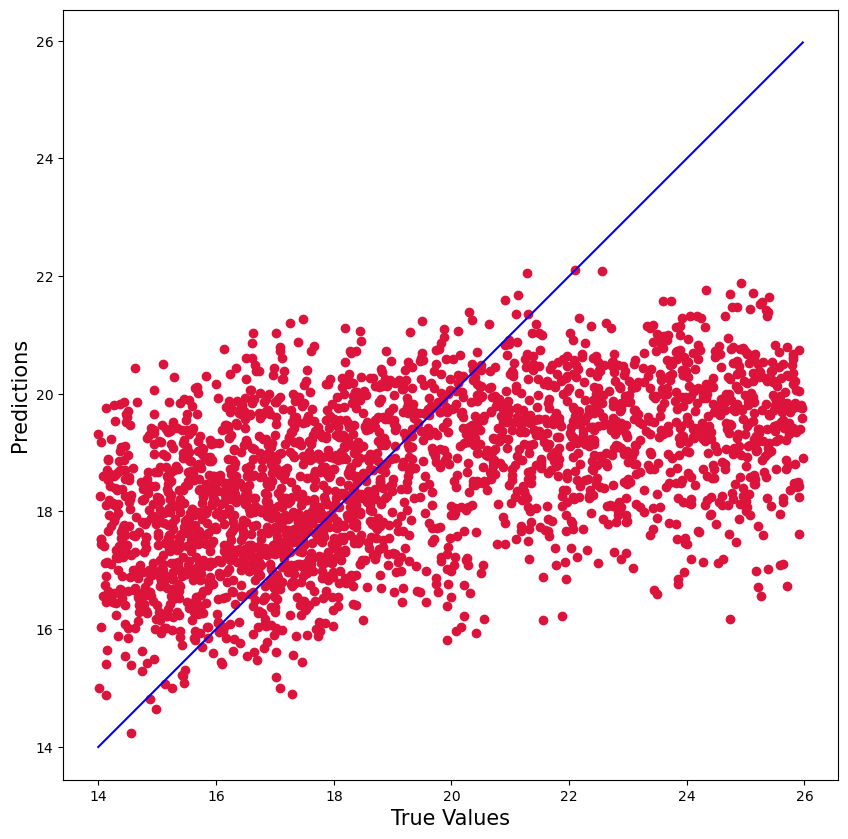

In [5]:
y_reel=test_ages
plt.figure(figsize=(10,10))
plt.scatter(y_reel, y_pred, c='crimson')
# plt.yscale('log')
# plt.xscale('log')

p1 = max(max(y_pred), max(y_reel))
p2 = min(min(y_pred), min(y_reel)) 
plt.plot([p1, p2], [p1, p2], 'b-') 
plt.xlabel('True Values', fontsize=15) 
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [6]:
cv_scores

[238.68601322174072,
 251.35838985443115,
 239.84301090240479,
 253.0900239944458,
 241.5278673171997]

In [7]:
 scores[0]

8.976491928100586

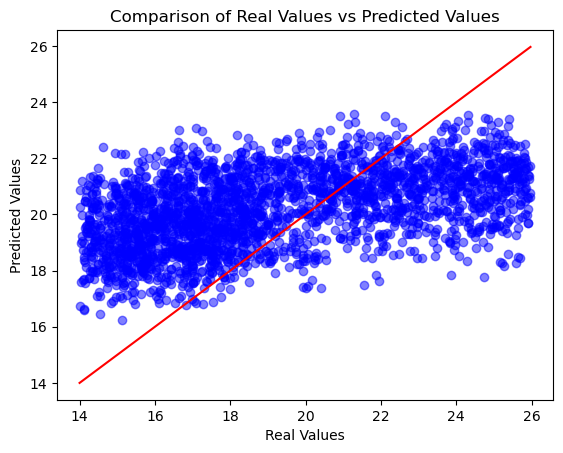

In [25]:
import matplotlib.pyplot as plt


plt.scatter(test_ages, y_pred, color='blue', alpha=0.5)

plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('Comparison of Real Values vs Predicted Values')

plt.plot([min(test_ages), max(test_ages)], [min(test_ages), max(test_ages)], color='red')

plt.show()



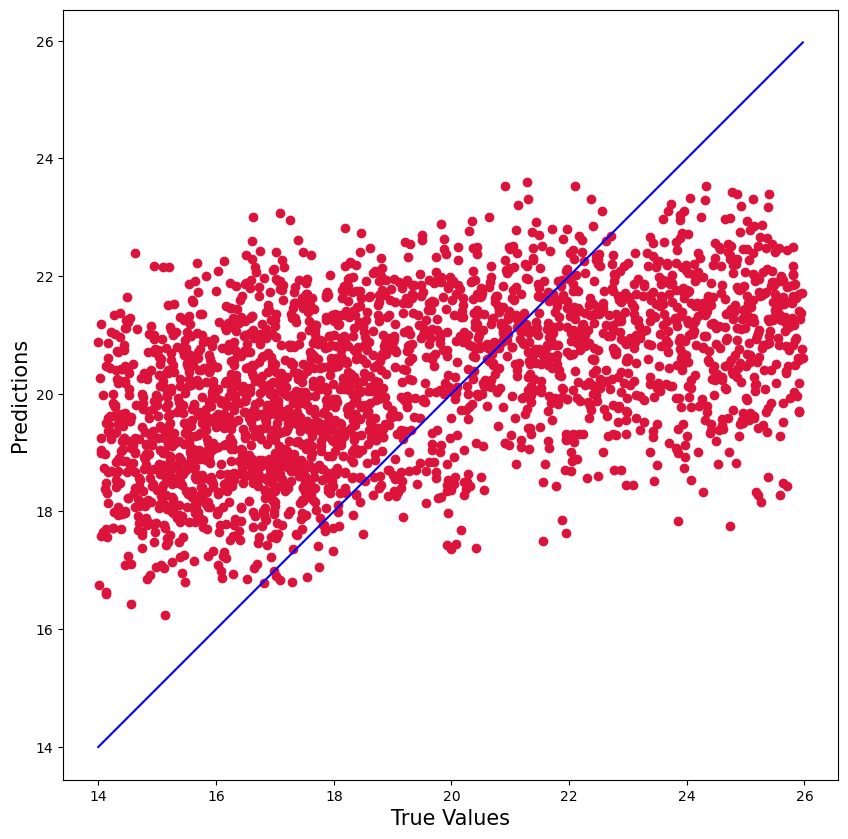

In [27]:
plt.figure(figsize=(10,10))
plt.scatter(test_ages, y_pred, c='crimson')
# plt.yscale('log')
# plt.xscale('log')

p1 = max(max(y_pred), max(test_ages))
p2 = min(min(y_pred), min(test_ages))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()


Text(0, 0.5, 'Predicted Age')

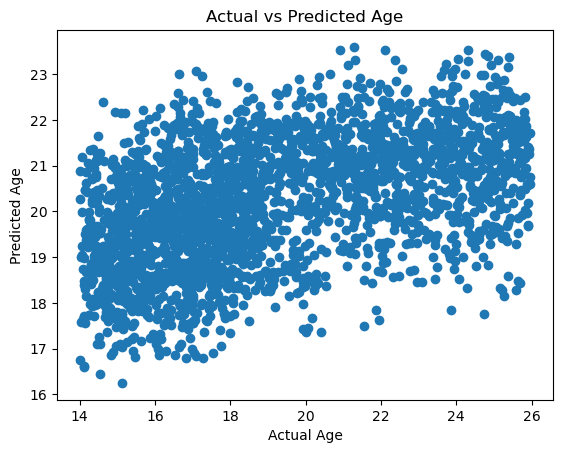

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot
plt.scatter(np.array(test_ages), y_pred)
plt.title("Actual vs Predicted Age")
plt.xlabel("Actual Age")
plt.ylabel("Predicted Age")





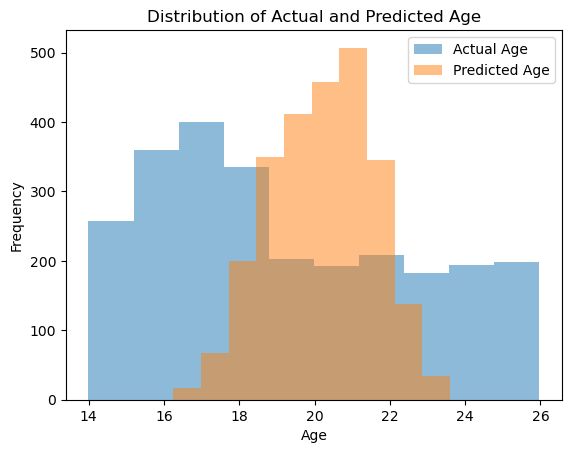

In [40]:
# Histogram
plt.hist(np.array(test_ages), alpha=0.5, label='Actual Age')
plt.hist(y_pred, alpha=0.5, label='Predicted Age')
plt.title("Distribution of Actual and Predicted Age")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.legend(loc='upper right')

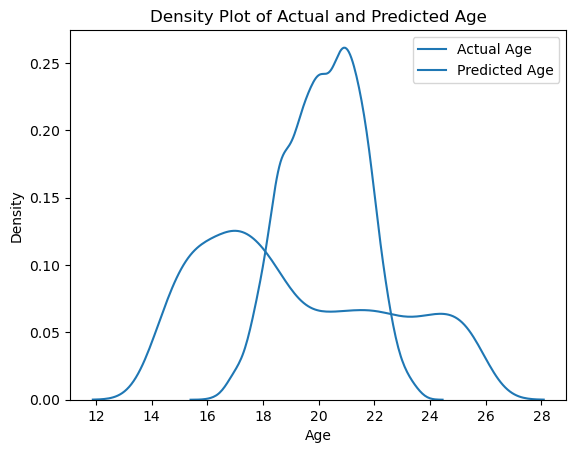

In [41]:
# Density Plot
sns.kdeplot(np.array(test_ages), label='Actual Age')
sns.kdeplot(y_pred, label='Predicted Age')
plt.title("Density Plot of Actual and Predicted Age")
plt.xlabel("Age")
plt.ylabel("Density")
plt.legend(loc='upper right')

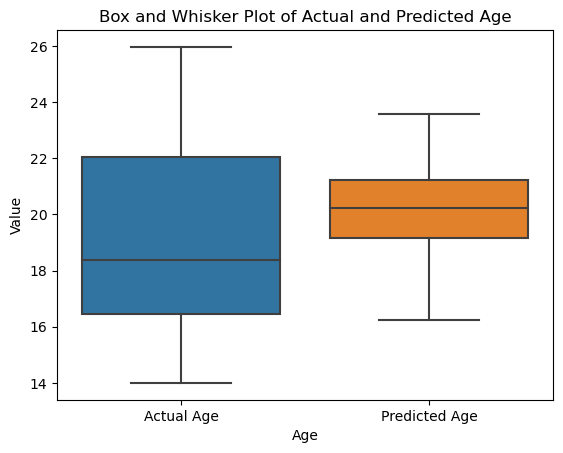

In [42]:
# Box and Whisker Plot
sns.boxplot(data=[np.array(test_ages), y_pred])
plt.title("Box and Whisker Plot of Actual and Predicted Age")
plt.xticks([0, 1], ['Actual Age', 'Predicted Age'])
plt.xlabel("Age")
plt.ylabel("Value")
plt.show()


In [4]:
test_ages.isna().sum()

NameError: name 'test_ages' is not defined

In [32]:
import math
math.isnan(test_ages)

TypeError: must be real number, not list

In [34]:
import math

def has_nan(list):
    for item in list:
        if math.isnan(item):
            return True
    return False

if has_nan(y_pred):
    print("List contains NaN")
else:
    print("List does not contain NaN")


List does not contain NaN


In [36]:
type(test_ages)

list

In [37]:
type(y_pred)

numpy.ndarray

In [44]:
import numpy as np
from sklearn.linear_model import LogisticRegression

# Seuillage des valeurs de y_pred et test_ages à 18 ans
y_binary = np.where(y_pred < 18, 0, 1)
test_ages_binary = np.where(np.array(test_ages) < 18, 0, 1)

# Création d'un modèle de régression logistique
logreg = LogisticRegression()

# Ajustement du modèle aux données
logreg.fit(X, y_binary)

# Prédiction avec le modèle entraîné
y_pred_logreg = logreg.predict(X)

# Évaluation du modèle
accuracy = logreg.score(X, y_binary)

NameError: name 'X' is not defined

In [9]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Seuillage des prédictions à 18 ans
y_pred_binary = np.where(y_pred < 18, 0, 1)

# Obtention des âges réels de l'ensemble de données de test
y_true = test_ages
y_true_binary= np.where((np.array(test_ages)) < 18, 0, 1)
y_true_binary = np.reshape(y_true_binary, (-1, 1))
error=np.mean(np.abs(y_pred_binary-y_true_binary))
# Calcul des erreurs de prédiction
mae = mean_absolute_error(y_true_binary, y_pred_binary)
rmse = np.sqrt(mean_squared_error(y_true_binary, y_pred_binary))
print('prediction_error',error)
print("MAE:", mae)
print("RMSE:", rmse)

prediction_error 0.2935126582278481
MAE: 0.2935126582278481
RMSE: 0.5417680852798992


In [10]:
y_pred_binary

array([[0],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [11]:
y_true_binary

array([[1],
       [0],
       [1],
       ...,
       [1],
       [0],
       [1]])

In [51]:
[score/100 for score in cv_scores]

[2.421048641204834,
 2.520031452178955,
 2.467458963394165,
 2.4658849239349365,
 2.665907621383667]

In [75]:
# Convert y_true_binary to a 2-dimensional array with the same shape as y_pred_binary
y_true_binary = np.reshape(y_true_binary, (-1, 1))

# Calculate the probability of prediction error
failure_prob = np.sum(y_pred_binary != y_true_binary) / len(y_true_binary)


In [76]:
failure_prob

0.40427215189873417

In [59]:
len(c)

2528

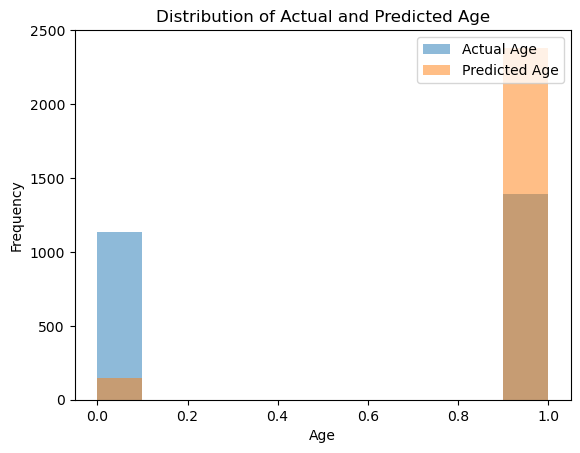

In [77]:
# Histogram
y_true_binary = np.reshape(y_true_binary, (-1, 1))
plt.hist(np.array(y_true_binary), alpha=0.5, label='Actual Age')
plt.hist(y_pred_binary, alpha=0.5, label='Predicted Age')
plt.title("Distribution of Actual and Predicted Age")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.legend(loc='upper right')

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_true_binary, y_pred_binary)
auc=roc_auc_score(y_true_binary, y_pred_binary)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Ligne en pointillés représentant la performance aléatoire
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

NameError: name 'roc_auc_score' is not defined

In [82]:
from sklearn.metrics import roc_auc_score
y_true_binary = np.reshape(y_true_binary, (-1, 1))
# y_true_binary : étiquettes binaires réelles (0/1)
# y_pred_prob : prédictions de probabilité pour la classe positive
auc = roc_auc_score(y_true_binary, y_pred_binary)
print("AUC-ROC:", auc)

AUC-ROC: 0.5518564815780804


In [102]:
from sklearn.metrics import roc_curve

# Assuming you have y_true and y_pred_binary as your true labels and predicted binary labels
y_true_binary = np.reshape(y_true_binary, (-1, 1))
# Calculate the fpr, tpr, and thresholds
fpr, tpr, thresholds = roc_curve(y_true_binary, y_pred_binary)

# Print the fpr, tpr, and thresholds
print("False Positive Rate (FPR):", fpr)
print("True Positive Rate (TPR):", tpr)
print("Thresholds:", thresholds)

False Positive Rate (FPR): [0.         0.88478452 1.        ]
True Positive Rate (TPR): [0.         0.98849748 1.        ]
Thresholds: [2 1 0]


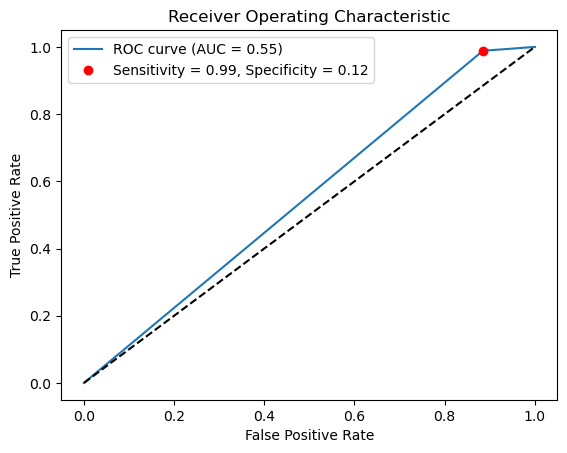

In [108]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculez les valeurs de FPR et TPR à partir des scores de probabilité prédits et des étiquettes de classe réelles
fpr, tpr, thresholds = roc_curve(y_true_binary, y_pred_binary)

# Calculez l'aire sous la courbe ROC
roc_auc = auc(fpr, tpr)

# Trouvez l'indice du point qui correspond à la sensibilité par rapport à la spécificité
index = np.argmax(tpr - fpr)

# Obtenez les coordonnées (FPR, TPR) du point de sensibilité par rapport à la spécificité
sensitivity = tpr[index]
specificity = 1 - fpr[index]

# Tracez la courbe ROC
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)

# Tracez le point de sensibilité par rapport à la spécificité
plt.plot(fpr[index], tpr[index], 'ro', label='Sensitivity = %0.2f, Specificity = %0.2f' % (sensitivity, specificity))

# Tracez la ligne diagonale pour référence
plt.plot([0, 1], [0, 1], 'k--')

# Ajoutez des légendes et des titres
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()

# Affichez le graphique
plt.show()

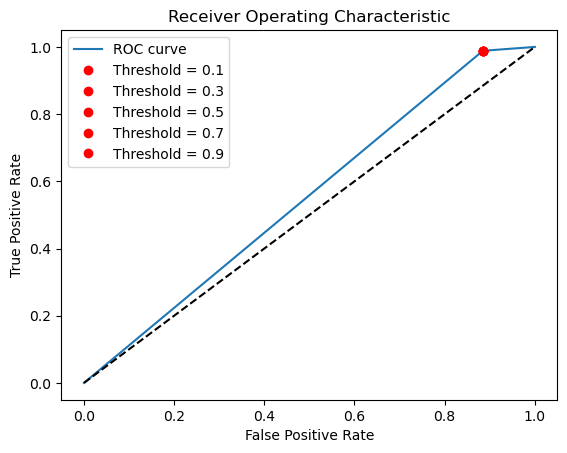

In [112]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute the FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_true_binary, y_pred_binary)

# Create an array of different threshold values
threshold_values = [0.1, 0.3, 0.5, 0.7, 0.9]

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve')

# Iterate over different threshold values
for threshold in threshold_values:
    # Compute the predicted labels based on the threshold
    y_pred = (y_pred_binary >= threshold).astype(int)
   
    # Compute the FPR and TPR for the current threshold
    fpr_threshold = np.sum((y_pred == 1) & (y_true_binary == 0)) / np.sum(y_true_binary == 0)
    tpr_threshold = np.sum((y_pred == 1) & (y_true_binary == 1)) / np.sum(y_true_binary == 1)
   
    # Plot the threshold point on the ROC curve
    plt.plot(fpr_threshold, tpr_threshold, 'ro', label='Threshold = {}'.format(threshold))

# Add the diagonal line for reference
plt.plot([0, 1], [0, 1], 'k--')

# Set the labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')

# Add the legend
plt.legend()

# Show the plot
plt.show()

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LogisticRegression
import pandas as pd
prediction_error= 0.40427215189873417
y_true_binary= np.where((np.array(test_ages)) < 18, 0, 1)
data = pd.DataFrame({'Age': y_true_binary, 'PredictionError': prediction_error})
num_knots = 5
data=data.sort_values(by='Age')
# Fit a univariate spline to the age variable
spline = UnivariateSpline(data['Age'], data['PredictionError'], k=num_knots)
# Generate a range of age values
age_range = np.linspace(data['Age'].min(), data['Age'].max(), 100)

# Calculate the predicted values using the spline
smoothed_age = spline(age_range)
# Prepare the data for logistic regression
X = smoothed_age.reshape(-1, 1)  # Reshape to a 2D array
y = np.where(data['PredictionError'] > 0, 1, 0)  # Convert prediction errors to binary labels

# Fit the logistic regression model
model = LogisticRegression()
model.fit(X, y)
# Plot the original data points
plt.scatter(data['Age'], data['PredictionError'], label='Original Data')

# Plot the smoothed age values
plt.plot(age_range, smoothed_age, color='red', label='Smoothed Age')

# Plot the logistic regression curve
log_reg_curve = model.predict_proba(X)[:, 1]  # Predict probabilities for positive class
plt.plot(age_range, log_reg_curve, color='green', label='Logistic Regression')

plt.xlabel('Age')
plt.ylabel('Prediction Error')
plt.legend()
plt.show()

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [1]:
y_pred

NameError: name 'y_pred' is not defined

In [5]:
y_pred_binary

NameError: name 'y_pred_binary' is not defined

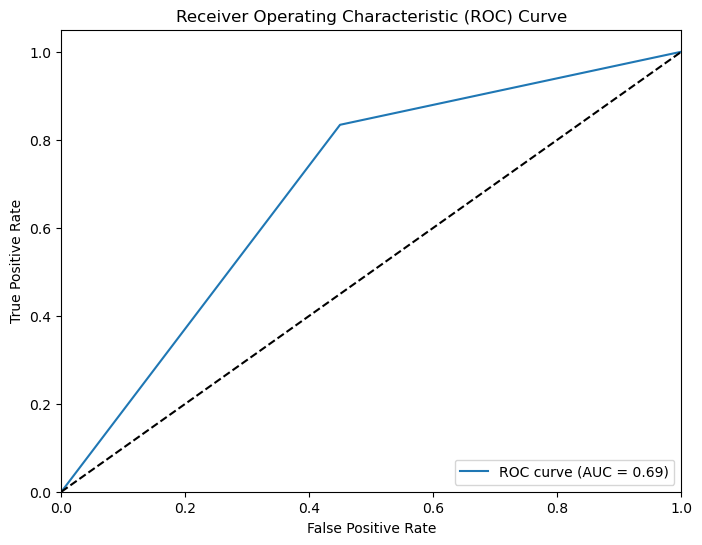

In [14]:
# Plotting ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve( y_true_binary, y_pred_binary)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc) 
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') 
plt.title('Receiver Operating Characteristic (ROC) Curve') 
plt.legend(loc="lower right")
plt.show()

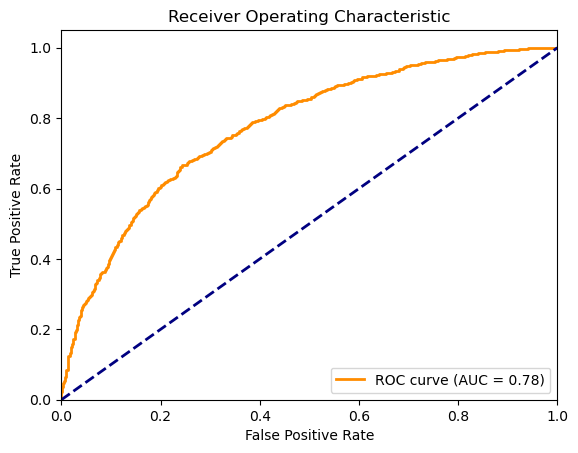

In [32]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc # Generate some example continuous predictions and true labels (ages) 
#y_pred = np.random.uniform(low=15, high=25, size=100) y_true = np.random.choice([0, 1], size=100) 
# Assuming binary true labels # Discretize predictions based on threshold of 18 years 
#y_pred_discrete = np.where(y_pred < 18, 1, 0)
# Calculate TPR and FPR 
thresholds=np.linspace(13,24,num=100)
for threshold in thresholds: 
    
    fpr, tpr, _ = roc_curve(y_true_binary, y_pred) 
    tpr_values.append(tpr[1]) # Append the TPR value for positive class 
    fpr_values.append(fpr[1]) # Append the FPR value for positive class (index 1) # 
#Calculate AUC
#fpr, tpr, thresholds = roc_curve(y_true_binary, y_pred_binary)
# Calculate AUC
roc_auc = auc(fpr, tpr) 
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc) 
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic') 
plt.legend(loc="lower right")
plt.show()

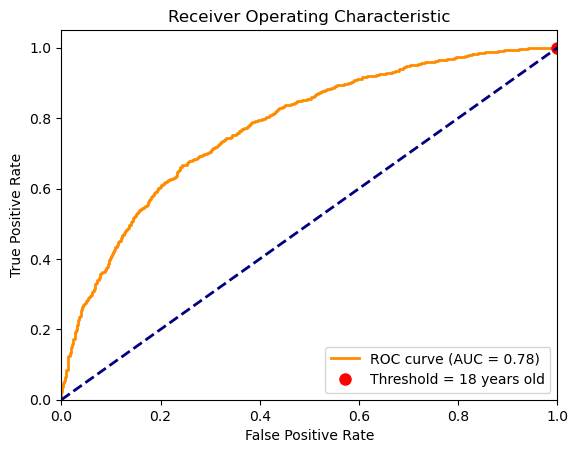

In [35]:
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_curve, auc
# Generate example outcome and predicted variables outcome = np.array(["Poor", "Poor", "Good", "Good", "Poor", "Good"]) predicted = np.array([0.2, 0.6, 0.8, 0.3, 0.1, 0.9]) 
# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds

fpr, tpr, thresholds = roc_curve(y_true_binary, y_pred) # Calculate the area under the ROC curve (AUC) 
roc_auc = auc(fpr, tpr) # Find the index of the threshold value closest to 18 
threshold_index = np.argmin(np.abs(thresholds - 0.18)) # Get the corresponding FPR and TPR values
fpr_point = fpr[threshold_index] 
tpr_point = tpr[threshold_index] # Plot the ROC curve 
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc) 
plt.plot(fpr_point, tpr_point, 'ro', markersize=8, label='Threshold = 18 years old')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05]) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right") 
plt.show()

In [26]:
y_bin = np.zeros_like(test_ages)
threshold=18
y_bin[test_ages>threshold] = 1
y_pred_bin=np.zeros_like(test_pred)
y_pred_bin[y_pred>=threshold] = 1

TypeError: '>' not supported between instances of 'list' and 'int'

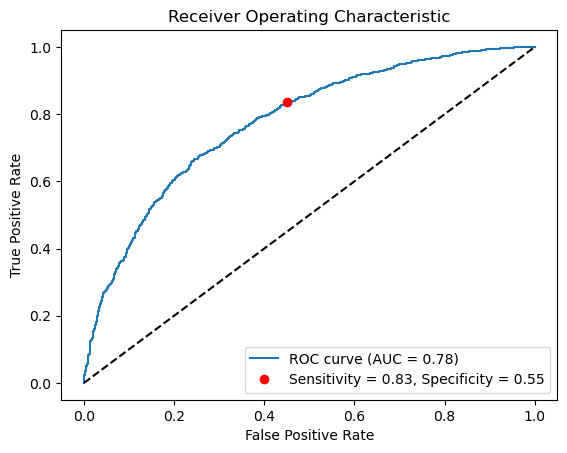

In [49]:
# Trouvez l'indice du point qui correspond à la sensibilité par rapport à la spécificité
index = np.abs(thresholds - 18).argmin()
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_true_binary, y_pred)
roc_auc = auc(fpr, tpr)

# Obtenez les coordonnées (FPR, TPR) du point de sensibilité par rapport à la spécificité
sensitivity = tpr[index]
specificity = 1 - fpr[index]

# Tracez la courbe ROC
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)

# Tracez le point de sensibilité par rapport à la spécificité
plt.plot(fpr[index], tpr[index], 'ro', label='Sensitivity = %0.2f, Specificity = %0.2f' % (sensitivity, specificity))

# Tracez la ligne diagonale pour référence
plt.plot([0, 1], [0, 1], 'k--')

# Ajoutez des légendes et des titres
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()

# Affichez le graphique
plt.show()

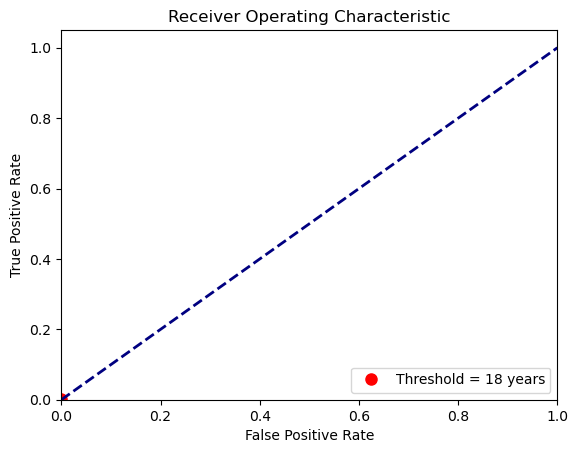

In [51]:
# Calculate TPR and FPR
thresholds = np.linspace(13, 24, num=100)
tpr_values = []
fpr_values = []
for threshold in thresholds:
    fpr, tpr, _ = roc_curve(y_true_binary, y_pred)
    tpr_values.append(tpr[1])
    fpr_values.append(fpr[1])
    # Recherche de l'indice correspondant au seuil de 18 ans
    threshold_index = np.where(thresholds == 18)[0][0]

    # Récupération du TPR et FPR correspondant au seuil de 18 ans
tpr_threshold = tpr_values[threshold_index]
fpr_threshold = fpr_values[threshold_index]

# Calculate AUC
roc_auc = auc(fpr_values, tpr_values)

# Plot ROC curve
plt.figure()
plt.plot(fpr_values, tpr_values, color='darkorange', lw=2)
plt.plot(fpr_threshold, tpr_threshold, 'ro', markersize=8, label='Threshold = 18 years')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
#Maintenant, les valeurs de TPR et FPR correspondant au seuil de 18 ans seront récupérées en dehors de la boucle for et utilisées pour tracer le point sur la courbe ROC.












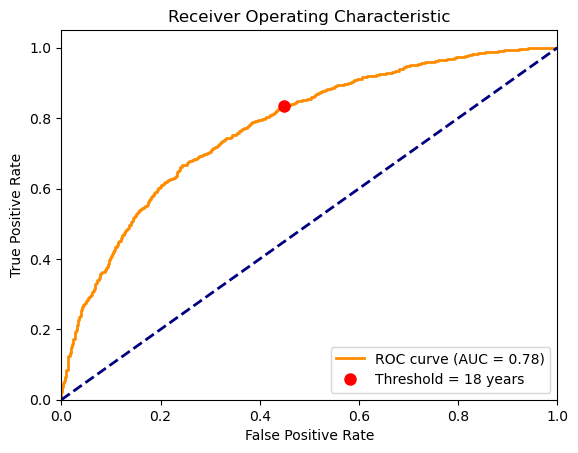

In [52]:

# Calculate TPR and FPR
fpr, tpr, thresholds = roc_curve(y_true_binary, y_pred)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Find the index corresponding to the threshold closest to 18
threshold_index = np.abs(thresholds - 18).argmin()

# Get the TPR and FPR corresponding to the threshold of 18
tpr_threshold = tpr[threshold_index]
fpr_threshold = fpr[threshold_index]

# Plot the point corresponding to the threshold of 18
plt.plot(fpr_threshold, tpr_threshold, 'ro', markersize=8, label='Threshold = 18 years')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Test data performance:
Accuracy: 0.71 (std=0.00)
Precision: 0.69 (std=0.00)
Recall: 0.83 (std=0.00)
F1-score: 0.76 (std=0.00)
ROC AUC score: 0.78 (std=0.00)


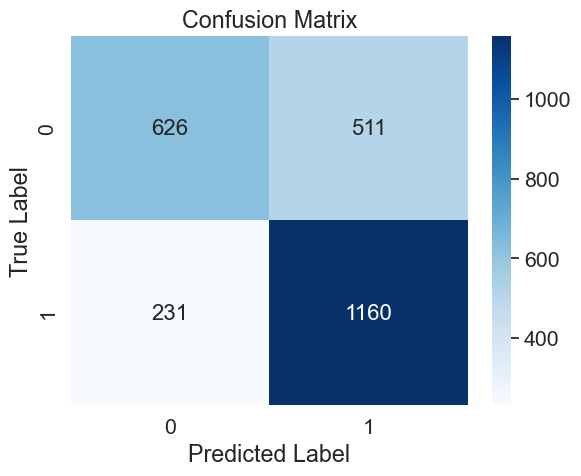

In [71]:
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
# Print the performance metrics
accuracy = accuracy_score(y_true_binary, y_pred_binary)
precision = precision_score(y_true_binary, y_pred_binary)
recall = recall_score(y_true_binary, y_pred_binary)
f1 = f1_score(y_true_binary, y_pred_binary)
roc_auc = roc_auc_score(y_true_binary, y_pred)
#ompute the standard deviation for each metric
std_accuracy = np.std(accuracy)
std_precision = np.std(precision)
std_recall = np.std(recall)
std_f1 = np.std(f1)
std_roc_auc = np.std(roc_auc)

print("Test data performance:")
print("Accuracy: %.2f (std=%.2f)" % (accuracy, std_accuracy))
print("Precision: %.2f (std=%.2f)" % (precision, std_precision))
print("Recall: %.2f (std=%.2f)" % (recall, std_recall))
print("F1-score: %.2f (std=%.2f)" % (f1, std_f1))
print("ROC AUC score: %.2f (std=%.2f)" % (roc_auc, std_roc_auc))

# Generate a confusion matrix for the test data
cm = confusion_matrix(y_true_binary, y_pred_binary)
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [62]:
STD=accuracy.std()
STD

0.0

In [65]:
np.std(precision)

0.0

In [69]:
metrics = [accuracy, precision, recall, f1, roc_auc]
std_metrics = np.std(precision)

In [70]:
std_metrics

0.0

In [ ]:
tb = mcnemar_table(y_target=y_target,
                   y_model1=y_model1,
                   y_model2=y_model2)

print(tb)
